### Tensorflow Non-linear Example 01
##### In this notebook, we illustrate the capability of Tensorflow neural networks for capturing/modeling inherent non-linearities in the target dataset.
##### Our model takes one single variable "x" as a predictor for our target "y", where the relationship between x and y is highly non-linear

###### >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  Ricardo Marques Domingues [11/20/2019]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from sklearn.model_selection import train_test_split

### Part-1: Creating our target non-linear datasets

#### 1.1 Defining the target and highly non-linear function that we will try to capture using tensorflow.

In [2]:
def tgt_function(x):
    return 1*np.sin(x*2*np.pi/20) + 0.6*np.cos(x*2*np.pi/50) + 0.4*np.sin(x*2*np.pi/90)

#### 1.2. Creating a continuous representation of the target function

In [3]:
x_range = [0.0, 100.0]
sample_size = 1500
# here is a continuous representation of the target function 
x_func = np.arange(x_range[0],x_range[1],0.01)
y_func = tgt_function(x_func)

#### 1.3 Sampling randomly observed values with noise

In [4]:
# Here are radanmly observed points, plus noise
x_obs = np.random.uniform(low=x_range[0], high=x_range[1], size=(sample_size))
y_obs = tgt_function(x_obs) + 0.5*np.random.randn(sample_size)
obs_df = pd.DataFrame({'x1_obs': x_obs, 'y_obs': y_obs})
obs_df.head()

,x1_obs,y_obs
0,61.809668,-0.051057
1,68.004759,-0.310906
2,54.359993,-0.218318
3,98.586578,-0.234284
4,35.983829,-1.270641


#### 1.4 - Splitting the observations into training (80%) & test data (20%)

In [5]:
obs_train, obs_test = train_test_split(obs_df, test_size=0.2)

# VARIATION #1: you may try separating training and test as a function of 
#   values of x, and see the impact on the reconstructed function
#   EXPECTED RESULT: because the model is trained with values of x<70, 
#                    it results in a poor performance extrapolating values > 70. 
# obs_train = obs_df.loc[obs_df['x1_obs']<=70]

#### 1.5 Plotting target function and observation values

Text(0.5, 0, 'x [e.g. time-units]')

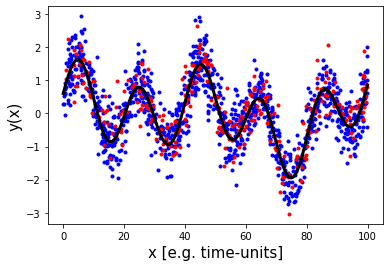

In [6]:
plt.plot(obs_train['x1_obs'],obs_train['y_obs'],'bo',ms=3)
plt.plot(obs_test['x1_obs'],obs_test['y_obs'],'ro',ms=3)
plt.plot(x_func,y_func,'k',lw=3)
plt.ylabel('y(x)',fontsize=15)
plt.xlabel('x [e.g. time-units]',fontsize=15)

In [7]:
train_labels = obs_train.pop('y_obs')
test_labels  = obs_test.pop('y_obs')

### Part-2 Building the model

In [8]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.3.0


In [9]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

#### 2.2 Building the Neural Network we will use

In [10]:
def build_model():
  # VARIATION #2: try changing the number of neurons (nodes of our NN), 
  #     and see the impact on the end result
  Neurons_to_Use = 100

  # VARIATION #3: try changing the number of hidden layers, making it shallower (less hidden layers), 
  #      or deeper (more hidden layers), and see the impact on the end result
  model = keras.Sequential([
    layers.Dense(Neurons_to_Use, activation='tanh', input_shape=[len(obs_train.keys())]),
    layers.Dense(Neurons_to_Use, activation='elu'), 
    layers.Dense(Neurons_to_Use, activation='elu'),
    layers.Dense(Neurons_to_Use, activation='elu'),      
    layers.Dense(Neurons_to_Use, activation='elu'),      
    layers.Dense(1, activation='linear'),
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
        
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [11]:
model = build_model()

# this will print the model structure, and number of parameters (weights) to be optmized
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 40,701
Trainable params: 40,701
Non-trainable params: 0
____________________________________________________

#### 2.3 Test that the untrained model gives an output in the format expected

In [12]:
example_batch = obs_train[:5]
example_result = model.predict(example_batch)
example_result

array([[-0.36043018],
       [-0.396087  ],
       [-0.3557971 ],
       [-0.38278285],
       [-0.3983378 ]], dtype=float32)

#### 2.4 Training the model and plotting the training progress against the original function

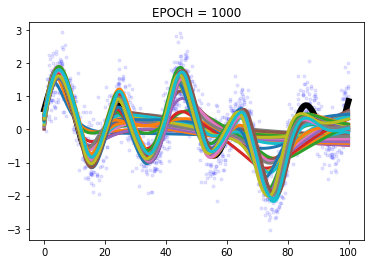

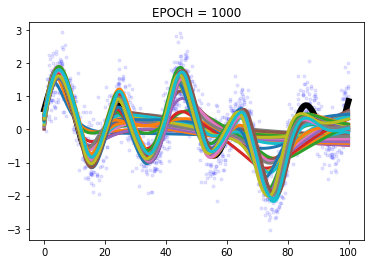

In [13]:
import pylab as pl
from IPython import display

EPOCHS = 20 #number of training epochs per loop

# The patience parameter is the amount of epochs to check for improvement
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

pl.plot(obs_df['x1_obs'],obs_df['y_obs'],'bo',ms=3,alpha=0.1)
pl.plot(x_func,y_func,'k',lw=6)
# pl.set_ylabel('y(x)',fontsize=15)
# pl.set_xlabel('x [e.g. time-units]',fontsize=15)

for i in range(50):
    train_incr = model.fit(obs_train, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0)#,callbacks=tfdocs.modeling.EpochDots())        
    fit_hist = ( pd.DataFrame(train_incr.history) if i ==0 else pd.concat([fit_hist,pd.DataFrame(train_incr.history)],ignore_index=True) )
    y_model = model.predict(x_func).flatten()
    pl.plot(x_func,y_model,lw=3)
    pl.title('EPOCH = {}'.format(EPOCHS*(i+1)) )
    display.clear_output(wait=True)
    display.display(pl.gcf())

#### 2.5 - plot the loss function training history

Text(0.5, 0, 'Training Epochs')

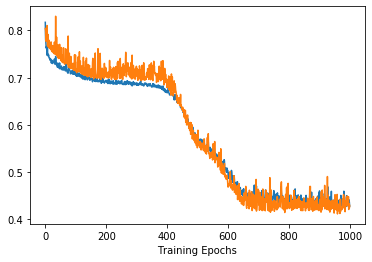

In [17]:
plt.plot(fit_hist['mae'])
plt.plot(fit_hist['val_mae'])
plt.xlabel('Training Epochs')

### FINAL NOTES:
#### For additional insight, try the following variations:
- VARIATION #1: you may try separating training and test as a function of values of x, and see the impact on the reconstructed function
- VARIATION #2: try changing the number of neurons (nodes of our NN), and see the impact on the end result
- VARIATION #3: try changing the number of hidden layers, making it shallower (less hidden layers),  or deeper (more hidden layers), and see the impact on the end result
- VARIATION #4: try changing the activation function from the hidden layers 